# Indexing and Selecting Data

## Learning Objectives

- Understanding the difference between position and label-based indexing
- Select data by position using `.isel` with values or slices
- Select data by label using `.sel` with values or slices
- Select timeseries data by date/time with values or slices
- Use nearest-neighbor lookups with `.sel`



## Introduction

Xarray offers extremely flexible indexing routines that combine the best features of NumPy and Pandas for data selection.

The most basic way to access elements of a `DataArray` object is to use Python’s `[]` syntax, such as `array[i, j]`, where `i` and `j` are both integers.

As xarray objects can store coordinates corresponding to each dimension of an array, label-based indexing similar to `pandas.DataFrame.loc` is also possible. In label-based indexing, the element position `i` is automatically looked-up from the coordinate values.

By leveraging the labeled dimensions and coordinates provided by Xarray, users can effortlessly access, subset, and manipulate data along multiple axes, enabling complex operations such as slicing, masking, and aggregating data based on specific criteria. 

This indexing and selection capability of Xarray not only enhances data exploration and analysis workflows but also promotes reproducibility and efficiency by providing a convenient interface for working with multi-dimensional data structures.

## Quick Overview 

In total, xarray supports four different kinds of indexing, as described below and summarized in this table:

| Dimension lookup | Index lookup | `DataArray` syntax   |   `Dataset` syntax   |
| ---------------- | ------------ | ---------------------| ---------------------|
| Positional       | By integer   | `da[:,0]`            | *not available*      |
| Positional       | By label     | `da.loc[:,'IA']`     | *not available*      |
| By name          | By integer   | `da.isel(space=0)` or `da[dict(space=0)]`  | `ds.isel(space=0)` or  `ds[dict(space=0)]`  |
| By name          | By label     | `da.sel(space='IA')` or `da.loc[dict(space='IA')]` | `ds.sel(space='IA')` or `ds.loc[dict(space='IA')]` |


----------

In this tutorial, first we cover the positional indexing and label-based indexing, next we will cover more advanced techniques such as nearest neighbor lookups. 

First, let's import packages: 

In [18]:
import numpy as np
import pandas as pd
import xarray as xr

Here we’ll use air temperature tutorial dataset from the [National Center for Environmental Prediction](https://www.weather.gov/ncep/). 

In [50]:
ds = xr.tutorial.load_dataset("air_temperature")
ds

<xarray.Dataset>
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 241.2 242.5 243.5 ... 296.5 296.2 295.7
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

In [51]:
da = ds["air"]

## Position-based Indexing

Indexing a `DataArray` directly works (mostly) just like it does for numpy `ndarrays`, except that the returned object is always another `DataArray`:



### NumPy Positional Indexing

When working with numpy, indexing is done by position (slices/ranges/scalars).

For example:

In [52]:
np_array = ds["air"].data  # numpy array
np_array.shape

(2920, 25, 53)

Indexing is 0-based in NumPy:

In [53]:
np_array[1, 0, 0]

242.09999

Similarly, we can select a range in NumPy:

In [54]:
# extract a time-series for one spatial location
np_array[:, 20, 40]

array([295.  , 294.4 , 294.5 , ..., 297.29, 297.79, 297.99], dtype=float32)

### Positional Indexing with Xarray

Xarray offers extremely flexible indexing routines that combine the best
features of NumPy and pandas for data selection.

#### NumPy style indexing with Xarray

NumPy style indexing works exactly the same with Xarray but it also preserves labels and metadata. 

In [55]:
da[:, 20, 40]

<xarray.DataArray 'air' (time: 2920)>
array([295.  , 294.4 , 294.5 , ..., 297.29, 297.79, 297.99], dtype=float32)
Coordinates:
    lat      float32 25.0
    lon      float32 300.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

```{caution}
Positional indexing deviates from the NumPy behavior when indexing with multiple arrays. 
```
We can show this with an example: 

In [56]:
np_array[:,[0, 1], [0, 1]].shape

(2920, 2)

In [57]:
da[:,[0, 1], [0, 1]].shape

(2920, 2, 2)

Please note how the dimension of the `DataArray()` object is different from the `numpy.ndarray`.

```{tip}
However, users can still achieve NumPy-like pointwise indexing across multiple labeled dimensions by using Xarray vectorized indexing techniques. We will delve further into this topic in the advanced indexing notebook.
```

#### Positional Indexing Using Dimension Names

Remembering the axis order can be challenging even with 2D arrays (is `np_array[0,3]` the first row and third column or first column and third row? or did I store these samples by row or by column when I saved the data?!). The difficulty is compounded with added dimensions. 

Xarray objects eliminate much of the mental overhead by adding indexing using dimension names:



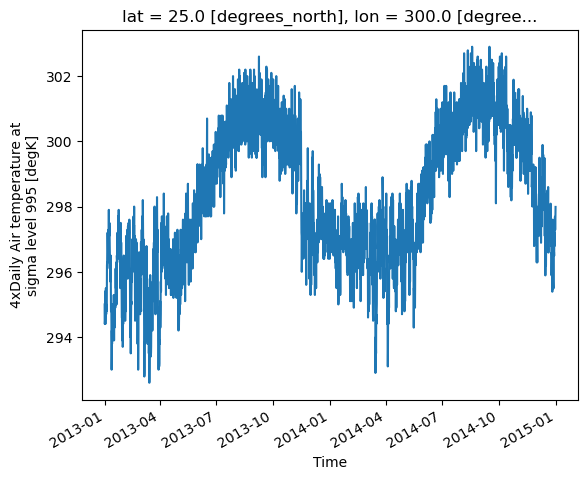

In [58]:
da.isel(lat=20, lon=40).plot();

Slicing is also possible similarly:

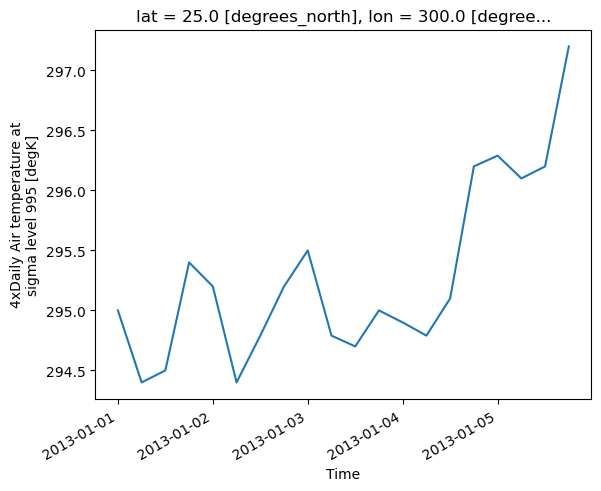

In [59]:
da.isel(time=slice(0, 20), lat=20, lon=40).plot();

```{note}
Using the `isel` method, the user can choose/slice the specific elements from a Dataset or DataArray.
```

But what if I wanted to select data only for 2014, how would I know the indices for it? Xarray reduce this complexity by introducing label-based indexing. 

## Label-based Indexing

To select data by coordinate labels instead of integer indices we can use the same syntax, using `sel` instead of `isel`:

For example, let's select the data for one day 2014-01-01 at Lat 25 N and Lon 210 E using `sel` :

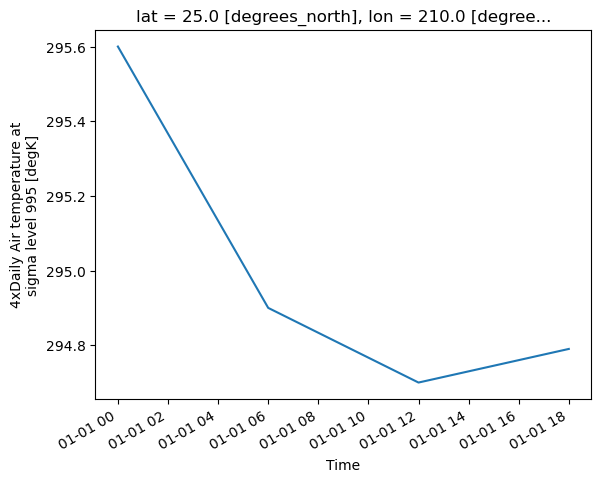

In [60]:
da.sel(time="2014-01-01", lat=25, lon=210).plot();

Now, let's select data for year 2014 at this coordinate:


In [61]:
da.sel(lat=50.0, lon=200.0, time="2014")

<xarray.DataArray 'air' (time: 1460)>
array([277.6 , 277.5 , 277.4 , ..., 277.59, 277.59, 277.59], dtype=float32)
Coordinates:
    lat      float32 50.0
    lon      float32 200.0
  * time     (time) datetime64[ns] 2014-01-01 ... 2014-12-31T18:00:00
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

Similarly we can do slicing or filter a date range using the `.slice` function: 

In [62]:
# demonstrate slicing
da.sel(time=slice("2014-02-14", "2014-12-13"))

<xarray.DataArray 'air' (time: 1212, lat: 25, lon: 53)>
array([[[246.     , 245.09999, 244.09999, ..., 240.2    , 242.     ,
         244.2    ],
        [240.59999, 241.7    , 242.09999, ..., 239.09999, 241.2    ,
         244.59999],
        [238.2    , 239.79999, 240.79999, ..., 243.89   , 246.89   ,
         251.2    ],
        ...,
        [295.6    , 295.6    , 296.     , ..., 293.6    , 293.6    ,
         294.1    ],
        [297.     , 297.     , 297.     , ..., 293.69998, 293.9    ,
         294.6    ],
        [297.5    , 297.69998, 297.69998, ..., 294.5    , 294.69998,
         295.19998]],

       [[245.2    , 244.29999, 243.     , ..., 241.89   , 243.09999,
         244.59999],
        [241.09999, 241.89   , 241.89   , ..., 241.89   , 243.59999,
         246.39   ],
        [239.89   , 241.     , 241.29999, ..., 245.09999, 248.2    ,
         252.2    ],
...
        [296.49   , 295.59   , 295.49   , ..., 297.29   , 297.38998,
         296.79   ],
        [298.09   , 297.79   , 297.19   , ..., 297.69   , 298.09   ,
         297.38998],
        [298.49   , 298.29   , 297.99   , ..., 298.29   , 298.09   ,
         297.99   ]],

       [[246.29   , 246.39   , 245.98999, ..., 232.29   , 233.39   ,
         234.98999],
        [246.68999, 248.18999, 248.98999, ..., 230.59   , 232.48999,
         235.68999],
        [244.79   , 245.29   , 245.89   , ..., 230.48999, 235.09   ,
         241.39   ],
        ...,
        [296.88998, 296.49   , 296.49   , ..., 297.69   , 297.29   ,
         296.19   ],
        [298.29   , 297.99   , 297.49   , ..., 298.29   , 298.38998,
         297.49   ],
        [298.49   , 298.29   , 297.99   , ..., 298.59   , 298.38998,
         298.29   ]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2014-02-14 ... 2014-12-13T18:00:00
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

Xarray also supports label-based indexing, just like pandas using `.loc`. Because we use a `pandas.Index` under the hood, label based indexing is very fast. To do label based indexing, use the `loc` attribute:

In [63]:
da.loc["2014-02-14":"2014-12-13"]

<xarray.DataArray 'air' (time: 1212, lat: 25, lon: 53)>
array([[[246.     , 245.09999, 244.09999, ..., 240.2    , 242.     ,
         244.2    ],
        [240.59999, 241.7    , 242.09999, ..., 239.09999, 241.2    ,
         244.59999],
        [238.2    , 239.79999, 240.79999, ..., 243.89   , 246.89   ,
         251.2    ],
        ...,
        [295.6    , 295.6    , 296.     , ..., 293.6    , 293.6    ,
         294.1    ],
        [297.     , 297.     , 297.     , ..., 293.69998, 293.9    ,
         294.6    ],
        [297.5    , 297.69998, 297.69998, ..., 294.5    , 294.69998,
         295.19998]],

       [[245.2    , 244.29999, 243.     , ..., 241.89   , 243.09999,
         244.59999],
        [241.09999, 241.89   , 241.89   , ..., 241.89   , 243.59999,
         246.39   ],
        [239.89   , 241.     , 241.29999, ..., 245.09999, 248.2    ,
         252.2    ],
...
        [296.49   , 295.59   , 295.49   , ..., 297.29   , 297.38998,
         296.79   ],
        [298.09   , 297.79   , 297.19   , ..., 297.69   , 298.09   ,
         297.38998],
        [298.49   , 298.29   , 297.99   , ..., 298.29   , 298.09   ,
         297.99   ]],

       [[246.29   , 246.39   , 245.98999, ..., 232.29   , 233.39   ,
         234.98999],
        [246.68999, 248.18999, 248.98999, ..., 230.59   , 232.48999,
         235.68999],
        [244.79   , 245.29   , 245.89   , ..., 230.48999, 235.09   ,
         241.39   ],
        ...,
        [296.88998, 296.49   , 296.49   , ..., 297.69   , 297.29   ,
         296.19   ],
        [298.29   , 297.99   , 297.49   , ..., 298.29   , 298.38998,
         297.49   ],
        [298.49   , 298.29   , 297.99   , ..., 298.59   , 298.38998,
         298.29   ]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2014-02-14 ... 2014-12-13T18:00:00
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

### Dropping using `drop_sel`

If instead of selecting data we want to drop it, we can use `drop_sel` method:

In [64]:
da.drop_sel(lat=50.0, lon=200.0, time="2014")

<xarray.DataArray 'air' (time: 2919, lat: 24, lon: 52)>
array([[[242.5    , 243.5    , 244.     , ..., 232.79999, 235.5    ,
         238.59999],
        [244.5    , 244.7    , 244.2    , ..., 232.79999, 235.29999,
         239.29999],
        [249.79999, 248.89   , 247.5    , ..., 233.2    , 236.39   ,
         241.7    ],
        ...,
        [296.19998, 296.4    , 296.5    , ..., 295.4    , 295.1    ,
         294.69998],
        [296.19998, 296.79   , 296.5    , ..., 295.9    , 295.9    ,
         295.19998],
        [296.79   , 297.1    , 297.     , ..., 296.9    , 296.79   ,
         296.6    ]],

       [[242.7    , 243.09999, 243.39   , ..., 232.     , 233.59999,
         235.79999],
        [244.09999, 244.2    , 244.09999, ..., 231.     , 232.5    ,
         235.7    ],
        [252.89   , 252.09999, 250.79999, ..., 230.79999, 233.39   ,
         238.5    ],
...
        [293.88998, 295.38998, 297.19   , ..., 295.09   , 294.69   ,
         294.29   ],
        [297.19   , 297.59   , 297.88998, ..., 295.29   , 295.09   ,
         294.38998],
        [298.38998, 298.49   , 298.59   , ..., 295.69   , 295.49   ,
         295.19   ]],

       [[244.29   , 243.29   , 242.18999, ..., 241.68999, 241.48999,
         241.79   ],
        [249.29   , 248.39   , 246.98999, ..., 239.59   , 240.29   ,
         241.68999],
        [262.19   , 261.38998, 259.99   , ..., 239.89   , 242.59   ,
         246.29   ],
        ...,
        [293.69   , 295.09   , 296.69   , ..., 295.29   , 295.09   ,
         294.69   ],
        [296.88998, 297.19   , 297.49   , ..., 295.69   , 295.69   ,
         295.19   ],
        [298.09   , 298.09   , 298.49   , ..., 296.49   , 296.19   ,
         295.69   ]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 202.5 205.0 207.5 210.0 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

So far, all the above will require us to specify exact coordinate values, but what if we don't have the exact values? We can use nearest neighbor lookups to address this issue:

## Nearest Neighbor Lookups

The label based selection methods `sel()` support `method` and `tolerance` keyword argument. The `method` parameter allows for enabling nearest neighbor (inexact) lookups by use of the methods `pad`, `backfill` or `nearest`:



In [65]:
da.sel(lat=52.25, lon=251.8998, method="nearest")

<xarray.DataArray 'air' (time: 2920)>
array([262.69998, 263.19998, 270.9    , ..., 264.19   , 265.19   ,
       266.99   ], dtype=float32)
Coordinates:
    lat      float32 52.5
    lon      float32 252.5
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

`tolerance` argument limits the maximum distance for valid matches with an inexact lookup:

In [66]:
da.sel(lat=52.25, lon=251.8998, method="nearest", tolerance=2)

<xarray.DataArray 'air' (time: 2920)>
array([262.69998, 263.19998, 270.9    , ..., 264.19   , 265.19   ,
       266.99   ], dtype=float32)
Coordinates:
    lat      float32 52.5
    lon      float32 252.5
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

```{tip}
All of these indexing methods work on the dataset too!
```

We can also use these methods to index all variables in a dataset simultaneously, returning a new dataset:

In [67]:
ds.sel(lat=52.25, lon=251.8998, method="nearest")

<xarray.Dataset>
Dimensions:  (time: 2920)
Coordinates:
    lat      float32 52.5
    lon      float32 252.5
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time) float32 262.7 263.2 270.9 274.1 ... 261.6 264.2 265.2 267.0
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

## Exercise

Practice the syntax you’ve learned so far:

```{exercise}
:label: indexing-1

Select the first 30 entries of `latitude` and 30th to 40th entries of `longitude`:
```

````{solution} indexing-1
:class: dropdown
```python
ds.isel(lat=slice(None, 30), lon=slice(30, 40))
```

````

```{exercise}
:label: indexing-2

Select all data at 75 degree north and between Jan 1, 2013 and Oct 15, 2013 :
```
````{solution} indexing-1
:class: dropdown
```python
ds.sel(lat=75, time=slice("2013-01-01", "2013-10-15"))
```
````

```{exercise}
:label: indexing-3

Remove all entries at 260 and 270 degrees :

```
````{solution} indexing-1
:class: dropdown
```python
ds.drop_sel(lon=[260, 270])
```
````

## Summary

In total, Xarray supports four different kinds of indexing, as described below and summarized in this table:

| Dimension lookup | Index lookup | `DataArray` syntax   |   `Dataset` syntax   |
| ---------------- | ------------ | ---------------------| ---------------------|
| Positional       | By integer   | `da[:,0]`            | *not available*      |
| Positional       | By label     | `da.loc[:,'IA']`     | *not available*      |
| By name          | By integer   | `da.isel(space=0)` or `da[dict(space=0)]`  | `ds.isel(space=0)` or  `ds[dict(space=0)]`  |
| By name          | By label     | `da.sel(space='IA')` or `da.loc[dict(space='IA')]` | `ds.sel(space='IA')` or `ds.loc[dict(space='IA')]` |


For enhanced indexing capabilities across all methods, you can utilize DataArray objects as an indexer. For more detailed information, please see the Advanced Indexing notebook.


## More Resources

- [Xarray Docs - Indexing and Selecting Data](https://docs.xarray.dev/en/stable/indexing.html)